In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

pd.set_option('display.max_columns', 500)

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

import visual_behavior.utilities as vbu

In [3]:
data_storage_directory = '~/temp'

cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 1.57MMB/s]
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 3.42MMB/s] 
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 2.83MMB/s]


In [5]:
dataloc = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/tidy_data'
osid = 973701907

In [10]:
%%time
fn = 'ophys_session_id={}.parquet'.format(osid)
session_df = pd.read_parquet(os.path.join(dataloc, fn))

CPU times: user 21.9 s, sys: 10.7 s, total: 32.5 s
Wall time: 6.83 s


In [11]:
len(session_df['cell_specimen_id'].unique())

1135

In [40]:
%%time
this_cell_df = session_df.query('cell_specimen_id == 1086512421')
etr = vbu.event_triggered_response(
    this_cell_df,
    parameter = 'dff',
    event_times = this_cell_df.query('image_name == "im000" and onset_frame')['timestamps'].unique(),
    t_before=3,
    t_after=3,
)
etr

CPU times: user 2.12 s, sys: 521 ms, total: 2.64 s
Wall time: 1.82 s


,time,dff,event_number,event_time
0,-3.000000,0.021007,0,308.63941
1,-2.983333,0.020890,0,308.63941
2,-2.966667,0.002734,0,308.63941
3,-2.950000,-0.015422,0,308.63941
4,-2.933333,-0.033578,0,308.63941
...,...,...,...,...
232555,2.916667,-0.064176,645,3883.64729
232556,2.933333,-0.086402,645,3883.64729
232557,2.950000,-0.108628,645,3883.64729
232558,2.966667,-0.130855,645,3883.64729


<AxesSubplot:xlabel='time', ylabel='dff'>

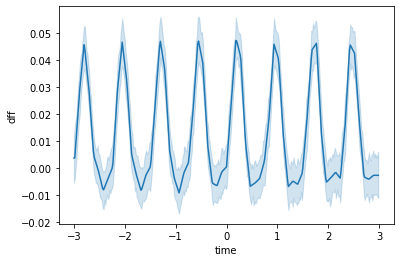

In [39]:
sns.lineplot(
    data=etr_vb,
    x='time',
    y='dff',
    n_boot=100
)

In [47]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = vbu.event_triggered_response(
        df,
        parameter = y,
        event_times = df.query(event_query)['timestamps'],
        t_before=t_before,
        t_after=t_before,
    )
    sns.lineplot(
        data=etr,
        x=x,
        y=y,
        n_boot=100,
        ax=ax
    )

In [45]:
image_names = [im for im in session_df['image_name'].unique() if im not in[None, 'omitted']]
image_names

['im000', 'im035', 'im106', 'im073', 'im031', 'im075', 'im054', 'im045']

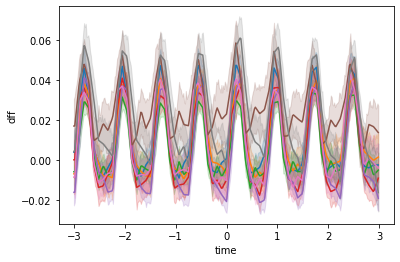

In [51]:
fig, ax = plt.subplots()

csid = 1086512421
for image_name in image_names:
    this_cell_df = session_df.query('cell_specimen_id == @csid')
    make_event_triggered_plot(
        df = session_df.query('cell_specimen_id == @csid'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'image_name == @image_name and onset_frame', 
        ax=ax
    )

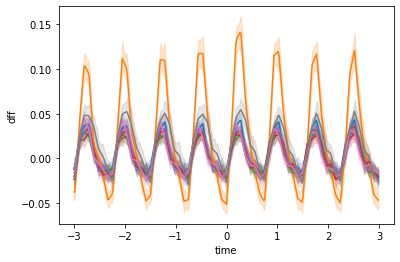

In [52]:
fig, ax = plt.subplots()

csid = 1086531274
for image_name in image_names:
    this_cell_df = session_df.query('cell_specimen_id == @csid')
    make_event_triggered_plot(
        df = session_df.query('cell_specimen_id == @csid'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'image_name == @image_name and onset_frame', 
        ax=ax
    )

In [53]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# get all unique images, excluding the omissions
image_identities = [im for im in session_df['image_name'].unique() if im not in [None, 'omitted']]

# set up an empty list that will contain all event triggered responses
full_etr = []

# iterate over every image and cell
for image_index, image_identity in enumerate(image_identities):
    for csid in session_df['cell_specimen_id'].unique():
        
        # a print statement to track progress
        print('on image_name {}, cell {}'.format(image_identity, csid), end = '\r')
        
        # get the event triggered response for all presentations of this image for this cell
        etr = vbu.event_triggered_response(
            session_df.query('cell_specimen_id == @csid'),
            parameter = 'dff',
            event_times = session_df.query('cell_specimen_id == @csid and image_name == @image_identity')['timestamps'],
            t_before = 0,
            t_after = 0.75
        )
        
        # append to the list
        full_etr.append(etr)

        # add a column with the cell_id and the image_identity
        full_etr[-1]['cell_specimen_id'] = csid
        full_etr[-1]['image_index'] = image_index
        full_etr[-1]['image_name'] = image_identity
                
# concatenate all dataframes into a single dataframe
full_etr = pd.concat(full_etr)